In [1]:
%pip install objgraph

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.comNote: you may need to restart the kernel to use updated packages.


In [3]:
!pip install xdot

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     -------------------------------------- 715.2/715.2 kB 1.0 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'error'


  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [12 lines of output]
      + meson setup C:\Users\diego\AppData\Local\Temp\pip-install-7b_j3y29\pygobject_7c21e6b08973400994faa1ccebb105ba C:\Users\diego\AppData\Local\Temp\pip-install-7b_j3y29\pygobject_7c21e6b08973400994faa1ccebb105ba\.mesonpy-0_nl14z_ -Dbuildtype=release -Db_ndebug=if-release -Db_vscrt=md -Dtests=false -Dwheel=true --wrap-mode=nofallback --native-file=C:\Users\diego\AppData\Local\Temp\pip-install-7b_j3y29\pygobject_7c21e6b08973400994faa1ccebb105ba\.mesonpy-0_nl14z_\meson-python-native-file.ini
      The Meson build system
      Version: 1.4.0
      Source dir: C:\Users\diego\AppData\Local\Temp\pip-install-7b_j3y29\pygobject_7c21e6b08973400994faa1ccebb105ba
      Build dir: C:\Users\diego\AppData\Local\Temp\pip-install-7b_j3y29\pygobject_7c21e6b08973400994faa1ccebb105ba\.mesonpy-0_nl14z_
      Build type: native build
      Project name: p

In [13]:
l = [1, 2, 3]
b = l
c = l
import objgraph
objgraph.show_backrefs(l, filename='sample-graph.png')

Graph written to C:\Users\diego\AppData\Local\Temp\objgraph-5dqyv3ez.dot (64 nodes)
Image generated as sample-graph.png


In [27]:
from concurrent.futures import ThreadPoolExecutor
from threading import local
import time
local_data = local()

def task_update(idx):
    local_data.value = idx
    print(f"{idx=} - Updated Value - {local_data.value=}")
    time.sleep(0.1)

def task_prior(idx):
    if hasattr(local_data, "value"):
        print(f"{idx=} - Prior Value - {local_data.value=}")
        time.sleep(0.1)


with ThreadPoolExecutor(max_workers=2) as executor:
    r = executor.map(task_update, [0, 1])
    for _ in r:
        pass
    executor.map(task_prior, [3, 4])


idx=0 - Updated Value - local_data.value=0
idx=1 - Updated Value - local_data.value=1
idx=3 - Prior Value - local_data.value=1
idx=4 - Prior Value - local_data.value=0


In [24]:
import time
import uuid
import threading
import concurrent.futures

thread_data = threading.local()

def conc_func(i):
   if not hasattr(thread_data, 'x'):
      thread_data.x = uuid.uuid4()
      print('Setting Thread Data: ', end='')
   else:
      print('Reading Thread Data: ', end='')
   print(thread_data.x)
   time.sleep(0.1)

with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
   _ = executor.map(conc_func, range(10))

Setting Thread Data: 661e40eb-4efc-4c3f-9192-9b61f9113a2f
Setting Thread Data: e32bd932-a018-4726-ba55-8a63c142e290
Setting Thread Data: 24192cb8-3e37-48b9-a3c8-e5b6434fdcf7
Setting Thread Data: a83aebb1-03d0-48f6-b305-b5eacbf7b0f0
Setting Thread Data: 4db91ea9-b370-4eee-8d7e-4082fded5bff
Reading Thread Data: 24192cb8-3e37-48b9-a3c8-e5b6434fdcf7
Reading Thread Data: e32bd932-a018-4726-ba55-8a63c142e290
Reading Thread Data: 4db91ea9-b370-4eee-8d7e-4082fded5bff
Reading Thread Data: a83aebb1-03d0-48f6-b305-b5eacbf7b0f0
Reading Thread Data: 661e40eb-4efc-4c3f-9192-9b61f9113a2f


In [30]:
from threading import Lock, Thread
import time

lock = Lock()

def task(n):
    lock.acquire()
    for i in range(n):
        print(i, end=" ")
        time.sleep(0.05)
    lock.release()

t1 = Thread(target=task, args=(3,))
t2 = Thread(target=task, args=(3,))
t1.start(), t2.start()
t1.join()
t2.join()



0 1 2 0 1 2 

In [32]:
def a(l):
    l.append(1)

l = []
a(l)
print(l)

[1]


In [33]:
from threading import Thread


def task(a, b):
    print(a, b)

t = Thread(target=task, kwargs={'a': 1, 'b': 2})
t.start()
t.join()


1 2


In [101]:
from time import perf_counter_ns # Really high resolution timer
from concurrent.futures import ThreadPoolExecutor
import pandas as pd

def task(n):
    start_time = perf_counter_ns()
    for _ in range(1_000_000 // n): # Each thread will do 1_000_000 // n iterations (Perfectly splitting the work)
        pass
    end_time = perf_counter_ns()
    ellapsed_ms = (end_time - start_time) / 1_000_000
    # print(f"Time taken: {ellapsed_ms} ns")
    return ellapsed_ms


N_REPETITIONS = 50
MAX_NUM_THREADS = 30

data = {}

with ThreadPoolExecutor(max_workers=MAX_NUM_THREADS) as executor:
    for n in range(1, MAX_NUM_THREADS + 1):
        l = []
        for _ in range(N_REPETITIONS):
            partial_times = list(executor.map(task, [n] * n)) # Run the task n times
            total_time = sum(partial_times)
            l.append(total_time)
        data[str(n)] = l
    

df = pd.DataFrame(data)
df.to_parquet('threading_benchmark.parquet')



In [154]:
import plotly.graph_objects as go
import numpy as np
import pandas as pd

N = 30     # Number of boxes

df_org = pd.read_parquet("C:/Users/diego/Documents/Git/playground/blog/posts/cuda_cohort_w1/resources/threading_benchmark.parquet")

# generate an array of rainbow colors by fixing the saturation and lightness of the HSL
# representation of colour and marching around the hue.
# Plotly accepts any CSS color format, see e.g. http://www.w3schools.com/cssref/css_colors_legal.asp.
c = ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 360, N)]



# Each box is represented by a dict that contains the data, the type, and the colour.
# Use list comprehension to describe N boxes, each with a different colour and with different randomly generated data:
fig = go.Figure(data=[go.Box(
    y=df_org.iloc[:, i].values,
    marker_color=c[i],
    name=str(i+1),
    ) for i in range(int(N))]
    
    )

# format the layout
fig.update_layout(
    xaxis=dict(zeroline=True, gridcolor="white", showgrid=True, zerolinecolor="white", ),
    yaxis=dict(gridcolor="white", zeroline=True, showgrid=True, zerolinecolor="white",),
    paper_bgcolor="rgb(248,248,248)",
    plot_bgcolor="rgb(248,248,248)",
    title=dict(
      text="Time Taken for One Million Iterations With Different Number of Threads",
      x=0.5, 
      y=0.95,
      font=dict(
        family="Times New Roman, serif",
        size=24),
      ),
    xaxis_title="Number of Threads Used",
    yaxis_title="Time (ms)",
    legend_title="Threads",
    margin=dict(l=40, r=40, t=40, b=40),
    font=dict(family="Times New Roman, serif", size=16),
    height=650,
    width=None
)
fig.update_yaxes(minor_ticks="inside",
                  minor=dict(
                    ticklen=6, 
                    tickcolor="black", 
                    tickmode='auto', 
                    nticks=10, 
                    showgrid=True
                    )
                )
fig.update_traces(boxmean=True)
fig.show(config={"responsive": True})

Pareciera que entre 3 y 8 threads, con pico en4 y 6, hay una disminuci'on considerable en performance, sobretodo en el long tail, pero tambi'en en media y mediana.


La hipótesis es la siguiente:

Todos los grupos de threads tienen en conjunto que hacer exactamente la misma cantidad de computación. No involucra I/O de ninguna clase, ni a memoria ni a red ni a disco, es completamente CPU-bound. Por lo tanto, las diferencias deberán ser por la cantidad de context switches que se hacen, y por la cantidad de cache misses que se producen al acceder a instrucciones en memoria

Procedimiento:

Vamos a contar el número de context switches que cada thread hace. Intentaremos sacar una correlación entre este número y el tiempo promedio que demora cada thread en ejecutar mil ciclos. Se esepra una fuerte correlación negativa.

Analizaremos tambien los box plots de context switches, a ver si cierto número de threads produce más context switches que otros.

In [100]:
from threading import current_thread
import psutil

p = psutil.Process()
thread = current_thread()

print(thread.ident)

for p_thread in p.threads():
    if p_thread.id == thread.ident:
        # print(p_thread.ctx_switches)
        pass

30752


In [164]:
p.num_ctx_switches().voluntary

62984

In [99]:
thread.name

'MainThread'

In [45]:
p.num_ctx_switches()

pctxsw(voluntary=23089, involuntary=0)

In [48]:
p.pid

27884

In [88]:
p.name()

'python.exe'

In [49]:
thread.ident

30752

In [202]:
from time import perf_counter_ns # High resolution timer
from concurrent.futures import ThreadPoolExecutor
import pandas as pd
import psutil

def task(n):
    start_time = perf_counter_ns()
    for _ in range(1_000_000 // n): # Each thread will do 1_000_000 // n iterations (Perfectly splitting the work)
        pass
    end_time = perf_counter_ns()
    ellapsed_ms = (end_time - start_time) / 1_000_000
    return ellapsed_ms


N_REPETITIONS = 50
MAX_NUM_THREADS = 30

data = {}
process = psutil.Process()

with ThreadPoolExecutor(max_workers=MAX_NUM_THREADS) as executor:
    for n in range(1, MAX_NUM_THREADS + 1):
        l = []
        switches = []
        for _ in range(N_REPETITIONS):
            init_ctx_switches = process.num_ctx_switches()
            init_ctx_switches = init_ctx_switches.voluntary + init_ctx_switches.involuntary
            partial_times = list(executor.map(task, [n] * n)) # Run the task n times
            end_ctx_switches = process.num_ctx_switches()
            end_ctx_switches = end_ctx_switches.voluntary + end_ctx_switches.involuntary
            ctx_switches = end_ctx_switches - init_ctx_switches
            total_time = sum(partial_times)
            l.append(total_time)
            switches.append(ctx_switches)
        data[str(n)] = l
        data[f"{n}_ctx_switches"] = switches
    

df = pd.DataFrame(data)
df.to_parquet('threading_benchmark_ctx_switches.parquet')

In [212]:
flattened_data = []

for key in data.keys():
    data_type = "Thread"
    if key.endswith("_ctx_switches"):
        data_type = "Context Switches"
    idx = key.split("_")[0]

    for value in data[key]:
        flattened_data.append({"Thread": idx, "Value": value, "Type": data_type})

flattened_df = pd.DataFrame(flattened_data)
flattened_df

,Thread,Value,Type
0,1,22.8487,Thread
1,1,19.8188,Thread
2,1,19.9995,Thread
3,1,19.7192,Thread
4,1,19.9530,Thread
...,...,...,...
2995,30,16.0000,Context Switches
2996,30,12.0000,Context Switches
2997,30,15.0000,Context Switches
2998,30,10.0000,Context Switches


In [306]:
import plotly.express as px
import plotly.graph_objs as go


threads_df = flattened_df[flattened_df.Type == "Thread"]
ctx_switches_df = flattened_df[flattened_df.Type == "Context Switches"]

threads_data = go.Box(x=threads_df["Thread"], y=threads_df["Value"], name="Time Taken (ms)", boxmean=True)
ctx_switches_data = go.Box(x=ctx_switches_df["Thread"], y=ctx_switches_df["Value"], name="Number of<br>Context Switches", boxmean=True, yaxis="y2")


# fig = px.box(flattened_df, x="Thread", y="Value", color="Type", boxmode="group", points="suspectedoutliers", log_y=True)
fig = go.Figure(data=[threads_data, ctx_switches_data])
fig.update_traces(quartilemethod="inclusive", boxmean=True) # or "inclusive", or "linear" by default
fig.update_layout(
    boxgap=0.3,
    boxmode='group',
    xaxis=dict(zeroline=True, gridcolor="white", showgrid=True, zerolinecolor="white", ),
    yaxis=dict(gridcolor="white", zeroline=True, showgrid=True, zerolinecolor="white", color="blue"),
    paper_bgcolor="rgb(248,248,248)",
    plot_bgcolor="rgb(248,248,248)",
    title=dict(
      text="<b>Visual Correlation of<br>Time Taken vs Context Switches</b>",
      x=0.3, 
      y=0.95,
      font=dict(
        family="Times New Roman, serif",
        size=24),
      ),
    xaxis_title="Number of Threads Used",
    yaxis_title="Time (ms)",
    margin=dict(l=40, r=40, t=40, b=40),
    font=dict(family="Times New Roman, serif", size=16),
    height=650,
    width=None,
    yaxis2=dict(
        title="Number of Context Switches",
        overlaying="y",
        side="right",
        showgrid=False,
        zeroline=False,
        type="log",
        color="red"
    )


)
fig.update_yaxes(minor_ticks="inside",
                  minor=dict(
                    ticklen=6, 
                    tickcolor="black", 
                    tickmode='auto', 
                    nticks=10, 
                    showgrid=True
                    ),
                    type="log"
                )
fig.show(config={"responsive": True})

In [195]:
corrs = []
for n in range(1, MAX_NUM_THREADS + 1):
    corrs.append(df[str(n)].corr(df[f"{n}_ctx_switches"]))

In [274]:
df.shape[1]//2

30

In [304]:
import plotly.graph_objects as go
import numpy as np

x = np.arange(1, len(corrs) + 1)
mean_corr = np.mean(corrs)

fig = go.Figure(data=go.Scatter(x=x, y=corrs, mode='lines+markers',))
fig.add_hline(y=mean_corr, line_dash="dot",
              annotation_text=f"<b>Mean Correlation<br>{mean_corr:.3f}</b>", 
              annotation_position="bottom right",
              annotation_font_size=16
              )

fig.update_layout(
    boxgap=0.3,
    boxmode='group',
    xaxis=dict(zeroline=True, gridcolor="white", showgrid=True, zerolinecolor="white", ),
    yaxis=dict(gridcolor="white", zeroline=True, showgrid=True, zerolinecolor="white"),
    # paper_bgcolor="rgb(248,248,248)",
    # plot_bgcolor="rgb(248,248,248)",
    title=dict(
      text="<b>Correlation of<br>Time and Context Switches</b>",
      x=0.5, 
      y=0.93,
      font=dict(
        family="Times New Roman, serif",
        size=24),
      ),
    xaxis_title="Number of Threads Used",
    yaxis_title="Pearson Correlation Coefficient",
    margin=dict(l=40, r=20, t=80, b=40),
    font=dict(family="Times New Roman, serif", size=16)


)
fig.update_yaxes(minor_ticks="inside",
                  minor=dict(
                    ticklen=6, 
                    tickcolor="black", 
                    tickmode='auto', 
                    nticks=6, 
                    showgrid=True
                    )
                )
fig.show(config={"responsive": True})

In [201]:
import plotly.express as px

df = px.data.tips()
df

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


<AxesSubplot: >

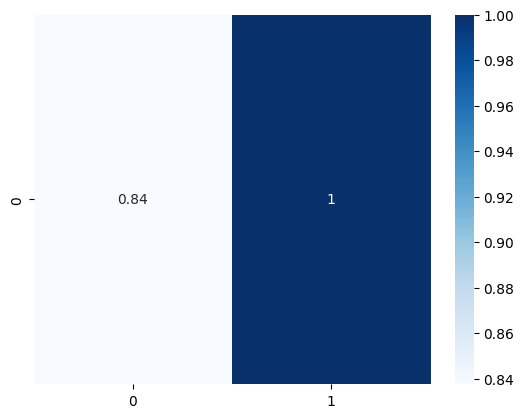

In [191]:
import seaborn as sns

import numpy as np

i = 1

corr = np.corrcoef(df[str(i)].values, df[f"{i}_ctx_switches"].values)
sns.heatmap([corr[:, 1]], cmap="Blues", annot=True)

In [193]:
np.corrcoef(df[str(i)].values, df[f"{i}_ctx_switches"].values)[0, 1]

0.8375310332902277

## Trying to find context switches numbers per each thread instead of the process total

In [120]:
import ctypes
from ctypes import wintypes
import win32pdh
import win32api
import time

def get_thread_context_switches(pid, tid):
    query_handle = win32pdh.OpenQuery()
    
    # Performance counter path for context switches of a specific thread
    path = f"\\Thread({pid}:{tid})\\Context Switches/sec"
    path = win32pdh.MakeCounterPath( (None, f"Thread(python/2)", None, None, -1, "Context Switches/sec") )
    counter_handle = win32pdh.AddCounter(query_handle, path)
    
    try:
        win32pdh.CollectQueryData(query_handle)
        time.sleep(1)
        win32pdh.CollectQueryData(query_handle)
        _, value = win32pdh.GetFormattedCounterValue(counter_handle, win32pdh.PDH_FMT_LONG)
    except Exception as e:
        print(f"Failed to get counter data: {e}")
        value = None
    
    win32pdh.CloseQuery(query_handle)
    return value

In [65]:
path = win32pdh.MakeCounterPath( (None,"Memory", None, None, -1, "Cache Faults/sec") )
path

'\\Memory\\Cache Faults/sec'

In [152]:
win32api.GetCurrentThreadId()

30752

In [150]:
path = win32pdh.MakeCounterPath( (None, "Thread", "2", "python", 0, "Context Switches/sec") 
                                )
path

'\\Thread(python/2)\\Context Switches/sec'

In [121]:
get_thread_context_switches(p.pid, thread.ident)

0

In [126]:
win32pdh.PERF_DETAIL_ADVANCED

200

In [142]:
win32pdh.ParseCounterPath('\\Thread(python/2)\\Context Switches/sec')

('\\\\DESKTOP-IQ736TQ', 'Thread', '2', 'python', 0, 'Context Switches/sec')

In [139]:
[s for s in win32pdh.ExpandCounterPath('\\Thread(*)\\Context Switches/sec') if 'python' in s]

['\\\\DESKTOP-IQ736TQ\\Thread(python/0#6)\\Context Switches/sec',
 '\\\\DESKTOP-IQ736TQ\\Thread(python/1#5)\\Context Switches/sec',
 '\\\\DESKTOP-IQ736TQ\\Thread(python/2#5)\\Context Switches/sec',
 '\\\\DESKTOP-IQ736TQ\\Thread(python/3#5)\\Context Switches/sec',
 '\\\\DESKTOP-IQ736TQ\\Thread(python/0#5)\\Context Switches/sec',
 '\\\\DESKTOP-IQ736TQ\\Thread(python/1#4)\\Context Switches/sec',
 '\\\\DESKTOP-IQ736TQ\\Thread(python/2#4)\\Context Switches/sec',
 '\\\\DESKTOP-IQ736TQ\\Thread(python/3#4)\\Context Switches/sec',
 '\\\\DESKTOP-IQ736TQ\\Thread(python/0#4)\\Context Switches/sec',
 '\\\\DESKTOP-IQ736TQ\\Thread(python/1#3)\\Context Switches/sec',
 '\\\\DESKTOP-IQ736TQ\\Thread(python/2#3)\\Context Switches/sec',
 '\\\\DESKTOP-IQ736TQ\\Thread(python/3#3)\\Context Switches/sec',
 '\\\\DESKTOP-IQ736TQ\\Thread(python/0#3)\\Context Switches/sec',
 '\\\\DESKTOP-IQ736TQ\\Thread(python/1#2)\\Context Switches/sec',
 '\\\\DESKTOP-IQ736TQ\\Thread(python/2#2)\\Context Switches/sec',
 '\\\\DESK

In [128]:
thread_win = win32pdh.EnumObjectItems(None, None, "Thread", win32pdh.PERF_DETAIL_WIZARD)
[s for s in thread_win[1] if "python" in s]

['python/0',
 'python/1',
 'python/2',
 'python/3',
 'python/0',
 'python/1',
 'python/2',
 'python/3',
 'python/0',
 'python/1',
 'python/2',
 'python/3',
 'python/0',
 'python/1',
 'python/2',
 'python/3',
 'python/0',
 'python/0',
 'python/1',
 'python/2',
 'python/3',
 'python/4',
 'python/5',
 'python/6',
 'python/7',
 'python/8',
 'python/9',
 'python/10',
 'python/11',
 'python/12',
 'python/13',
 'python/14',
 'python/15',
 'python/16',
 'python/17',
 'python/18',
 'python/19',
 'python/20',
 'python/21',
 'python/22',
 'python/23',
 'python/24',
 'python/25',
 'python/26',
 'python/27',
 'python/0',
 'python/1',
 'python/2',
 'python/3']

In [119]:
win32pdh.

error: (-1073738796, 'LookupPerfIndexByName', 'Unable to find the specified string in the list of performance name and  explain text strings.')

In [51]:
%pip install wmi

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [52]:
import wmi

def get_thread_context_switches_wmi(pid):
    c = wmi.WMI()
    threads = c.Win32_Thread(ProcessId=pid)
    
    for thread in threads:
        print(f"Thread ID: {thread.ThreadId}, Context Switches: {thread.ContextSwitches}")

get_thread_context_switches_wmi(p.pid)

x_wmi_invalid_query: <x_wmi: Unexpected COM Error (-2147217385, 'OLE error 0x80041017', None, None)>

Veremos cómo se comportan los datos anteriores si modificamos el nivel de prioridad de los threads. Será posible que ciertos threads tengan más prioridad que otros, y por lo tanto se ejecuten más veces que otros?urr

In [17]:
import win32api


tid = win32api.GetCurrentThreadId()

print(tid)

30752


In [ ]:
import win32con

handle = win32api.OpenThread(win32con.THREAD_ALL_ACCESS, False, tid)

In [18]:
import win32con
win32con.

AttributeError: module 'win32con' has no attribute 'THREAD_ALL_ACCESS'

In [21]:
import psutil

process = psutil.Process()

process.nice()

<Priority.NORMAL_PRIORITY_CLASS: 32>